<a href="https://colab.research.google.com/github/morenaherrera2/AA2-HerreraM-NardiG-ZorzoloJ/blob/main/Problema_3_TP1_AA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico 1 AAII 2025 - Redes Densas y Convolucionales

**PROBLEMA 3 -GRUPO N° 5**

Autores:
- Herrera Morena (H-1187/8)
- Nardi Gianella Belén (N-1277/7)
- Zorzolo Rubio Juana (Z-1217/3)

# Problema 3



**Descripción**: En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de todo el mundo. El objetivo es construir un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.

## Instalaciones e importaciones

In [ ]:
!pip install -q gdown

In [ ]:
import gdown
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path

from tensorflow.keras.layers import Input, RandomFlip, RandomContrast, RandomTranslation, Flatten, Dropout
from tensorflow.keras.layers import Dense, Conv2D, Activation, MaxPooling2D, Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Add, ReLU, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization

from PIL import Image
from collections import Counter, defaultdict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from IPython.display import Image
import os
import tempfile

In [ ]:
# Establecemos GPU por defecto si está disponible
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# Fijar semilla
import random
semilla = 42
np.random.seed(semilla)
tf.random.set_seed(semilla)
random.seed(semilla)

In [ ]:
# TP1-3-natural-scenes.zip
gdown.download('https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ')

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=4509aa3a-43b9-49d3-ab03-efb7aed343e2
To: /content/TP1-3-natural-scenes.zip
100%|██████████| 363M/363M [00:06<00:00, 55.2MB/s]


'TP1-3-natural-scenes.zip'

In [ ]:
with zipfile.ZipFile('TP1-3-natural-scenes.zip', 'r') as zip_ref:
  zip_ref.extractall('./TP1-3')

## Análisis y preprocesamiento de datos (EDA)

In [ ]:
# Directorio de los datos
data_train = Path('/content/TP1-3/seg_train/seg_train')
data_test = Path('/content/TP1-3/seg_test/seg_test')

BATCH_SIZE = 32 # Tamaño del lote

# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

# Cargamos los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_train,
  label_mode="categorical",
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_test,
  label_mode="categorical",
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [ ]:
# Inspeccionamos las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Total de imágenes analizadas (hasta 440 batches): 14034
Tamaños encontrados: {(150, 150, 3)}
Conteo por clase:
  - buildings: 2191 imágenes
  - forest: 2271 imágenes
  - glacier: 2404 imágenes
  - mountain: 2512 imágenes
  - sea: 2274 imágenes
  - street: 2382 imágenes


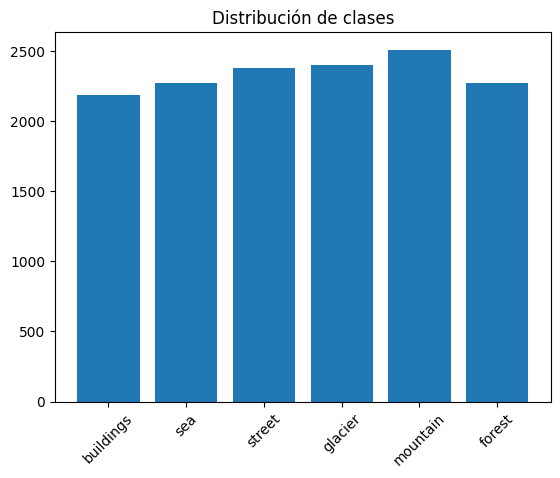

In [ ]:
# Vemos la distribución de las clases del conjunto de datos TRAIN
def analizar_dataset_tf(train_ds, class_names=None, max_batches=440):
  conteo_clases = Counter()
  tamaños = set()
  total_imgs = 0

  for batch, (images, labels) in enumerate(train_ds.take(max_batches)):
    batch_size = images.shape[0]
    total_imgs += batch_size
    tamaños.update([tuple(images.shape[1:4])])

    for label in labels.numpy():
      idx = np.argmax(label)
      conteo_clases[idx] += 1

  print(f"Total de imágenes analizadas (hasta {max_batches} batches): {total_imgs}")
  print("Tamaños encontrados:", tamaños)

  print("Conteo por clase:")
  for idx, count in sorted(conteo_clases.items()):
    nombre = class_names[idx] if class_names else f"Clase {idx}"
    print(f"  - {nombre}: {count} imágenes")

  # Plot de clases
  if class_names:
    etiquetas = [class_names[idx] for idx in conteo_clases.keys()]
  else:
    etiquetas = list(conteo_clases.keys())

  plt.bar(etiquetas, conteo_clases.values())
  plt.xticks(rotation=45)
  plt.title("Distribución de clases")
  plt.show()

class_names = train_ds.class_names if hasattr(train_ds, 'class_names') else ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
analizar_dataset_tf(train_ds, class_names, max_batches=440)

Total de imágenes analizadas (hasta 440 batches): 3000
Tamaños encontrados: {(150, 150, 3)}
Conteo por clase:
  - buildings: 437 imágenes
  - forest: 474 imágenes
  - glacier: 553 imágenes
  - mountain: 525 imágenes
  - sea: 510 imágenes
  - street: 501 imágenes


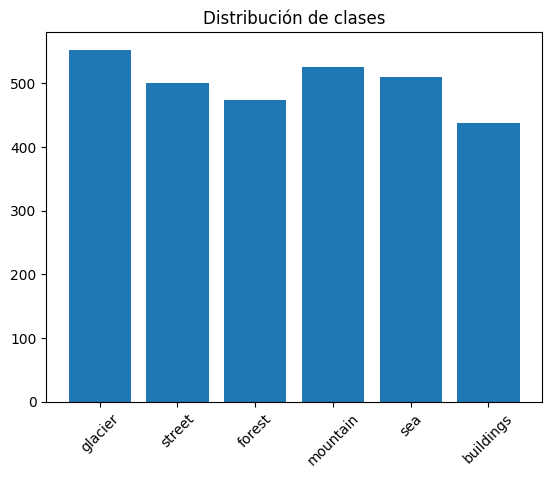

In [ ]:
# Vemos la distribución de las clases del conjunto de datos TEST
analizar_dataset_tf(test_ds, class_names, max_batches=440)

Conclusión: Si bien las clases no tienen exactamente la misma cantidad de imágenes, la diferencia entre la que más tiene y la que menos tiene es relativamente baja (alrededor del 10-25%), por lo que concluimos que el conjunto de datos está relativamente balanceado.


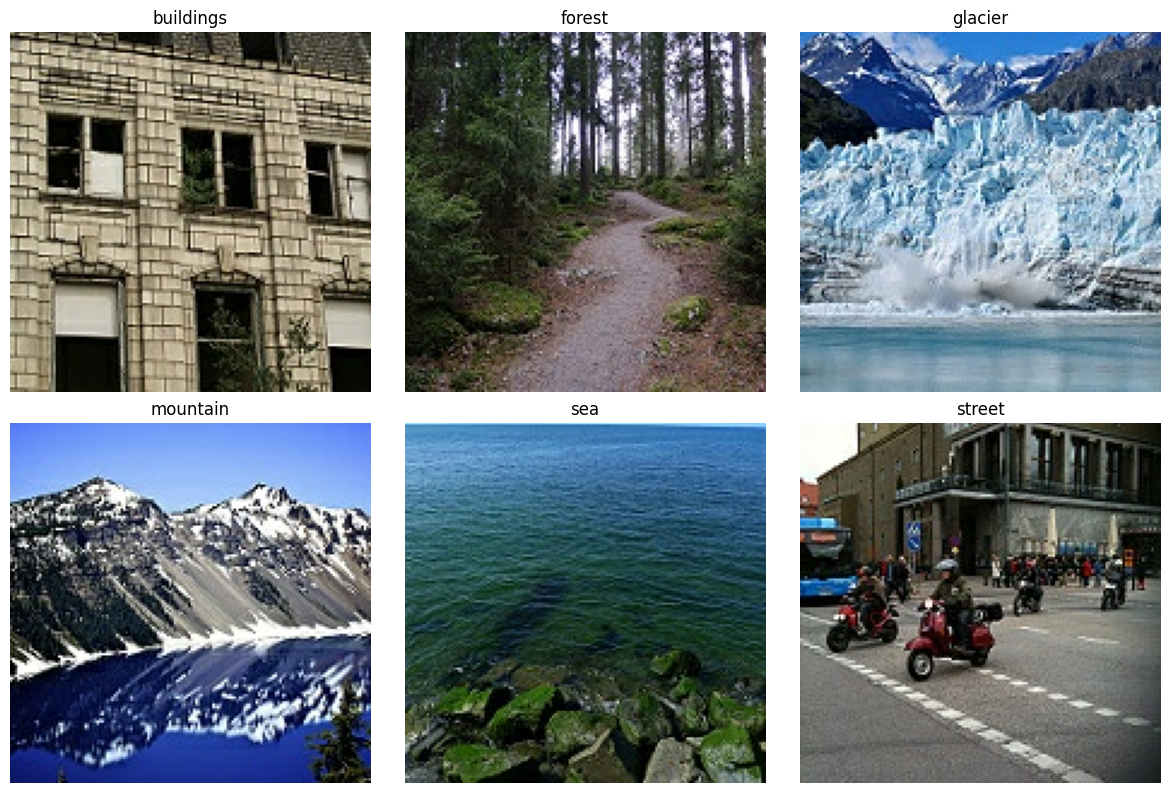

In [ ]:
# Mostramos imágenes por clase
def mostrar_ejemplos_por_clase(dataset, class_names):
  fig, axes = plt.subplots(2, 3, figsize=(12, 8))
  mostradas = [False] * len(class_names)

  for images, labels in dataset.unbatch().take(1000):
    idx = np.argmax(labels.numpy())
    if not mostradas[idx]:
      ax = axes[idx // 3, idx % 3]
      ax.imshow(images.numpy().astype("uint8"))
      ax.set_title(class_names[idx])
      ax.axis("off")
      mostradas[idx] = True
    if all(mostradas):
      break

  plt.tight_layout()
  plt.show()

# Del conjunto de datos TRAIN
mostrar_ejemplos_por_clase(train_ds, class_names)

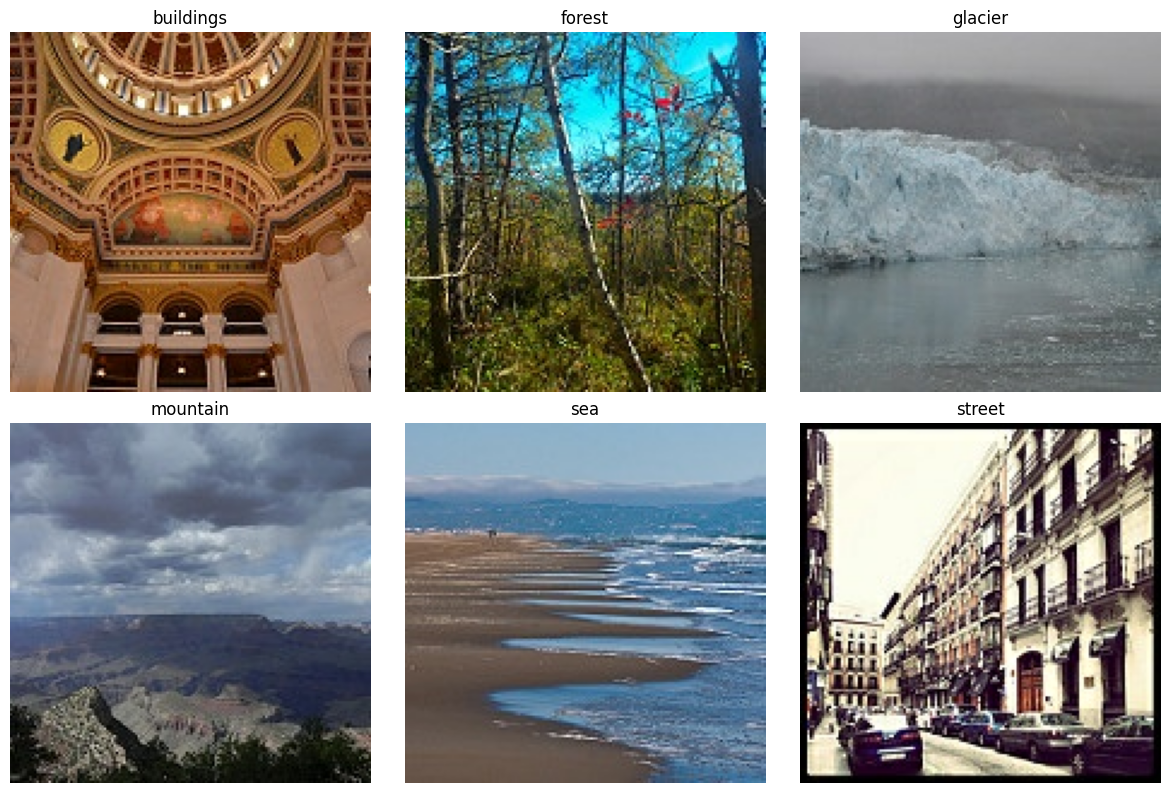

In [ ]:
# Del conjunto de datos TEST
mostrar_ejemplos_por_clase(test_ds, class_names)

In [ ]:
# Vemos valores de píxeles
for images, _ in train_ds.take(1):
  print("Mínimo valor de pixel:", images.numpy().min())
  print("Máximo valor de pixel:", images.numpy().max())

Mínimo valor de pixel: 0.0
Máximo valor de pixel: 255.0


Conclusión del Análisis y Preprocesamiento de los datos (EDA):

Este análisis nos indica que las imágenes son todas de un mismo tamaño y tienen un rango de valores adecuado. Además, las distribuciones por clase se encuentran relativamente balanceadas tanto en train como en test.
Los ejemplos de imágenes que visualizamos etiquetados con sus respectivas clases son coherentes con cada categoría.

## Definición y entrenamiento de modelos

Descomentar en caso de que se quiera reducir el tamaño del dataset para simular otro escenario o el tiempo de ejecución.


In [ ]:
#train_ds = train_ds.take(7500)
#test_ds = test_ds.take(1500)

A continuación se definen funciones de utilidad en todos los modelos.

In [ ]:
def plot_confusion_matrix(model, test_ds):
  class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
  y_pred = np.argmax(model.predict(test_ds), axis=1)

  y_true = np.concatenate([y for x, y in test_ds])
  y_true = np.argmax(y_true, axis=1)

  # Matriz de Confusión
  cm = confusion_matrix(y_true, y_pred)

  # Mostrar la matriz visual
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap='Blues', xticks_rotation=45)
  plt.title("Matriz de Confusión")
  plt.show()

  # Mostrar con nombres de clases
  cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
  print("\nMatriz de Confusión con Nombres de Clases:")
  print(cm_df)

In [ ]:
def plot_training(historia, nombre_modelo):
  acc = historia.history['accuracy']
  val_acc = historia.history['val_accuracy']
  loss = historia.history['loss']
  val_loss = historia.history['val_loss']
  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, 'bo-', label='Train accuracy')
  plt.plot(epochs, val_acc, 'ro-', label='Val accuracy')
  plt.title(f'Accuracy - {nombre_modelo}')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, 'bo-', label='Train loss')
  plt.plot(epochs, val_loss, 'ro-', label='Val loss')
  plt.title(f'Loss - {nombre_modelo}')
  plt.legend()

  plt.tight_layout()
  plt.show()

### Modelo con capas densas

In [ ]:
# Modelo simple de capas densas
def crear_modelo_denso(input_shape, num_classes):
  modelo = Sequential([
    Input(shape=input_shape),
    Rescaling(1./255),                        # Normalización
    Flatten(),                                # Aplanado
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(100, activation='relu'),
    Dense(num_classes, activation='softmax')  # Salida multicategoría
  ])
  return modelo

# Creamos el modelo
modelo_denso = crear_modelo_denso((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

# Compilamos el modelo
modelo_denso.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks para evitar overfitting
callbacks = [
  EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
  ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
]

# Entrenamiento del modelo
historial_denso = modelo_denso.fit(train_ds, validation_data=test_ds, epochs=20, callbacks=callbacks)

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.2738 - loss: 4.8825 - val_accuracy: 0.3497 - val_loss: 1.5500 - learning_rate: 0.0010
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.3240 - loss: 1.5743 - val_accuracy: 0.3833 - val_loss: 1.4833 - learning_rate: 0.0010
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.3493 - loss: 1.5387 - val_accuracy: 0.3643 - val_loss: 1.4725 - learning_rate: 0.0010
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3547 - loss: 1.5380 - val_accuracy: 0.4287 - val_loss: 1.4401 - learning_rate: 0.0010
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.3684 - loss: 1.5237 - val_accuracy: 0.4187 - val_loss: 1.4192 - learning_rate: 0.0010
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3683 - loss: 1.5129 - val_accuracy: 0.4187 - val_loss: 1.4283 - learning_rate: 0.0010
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.3824 - loss:

#### Modelo

In [ ]:
modelo_denso.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    17,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,979,976 (198.29 MB)

 Trainable params: 17,326,658 (66.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,653,318 (132.19 MB)

#### Evaluación

In [ ]:
# Evaluamos el modelo en el conjunto de datos TEST
loss, accuracy = modelo_denso.evaluate(test_ds)
print(f"Pérdida en test: {loss:.4f}")
print(f"Precisión en test: {accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4365 - loss: 1.3805
Pérdida en test: 1.3983
Precisión en test: 0.4307


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


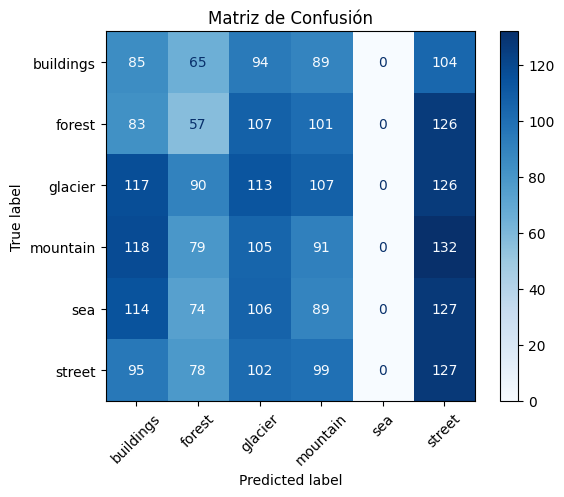


Matriz de Confusión con Nombres de Clases:
           buildings  forest  glacier  mountain  sea  street
buildings         85      65       94        89    0     104
forest            83      57      107       101    0     126
glacier          117      90      113       107    0     126
mountain         118      79      105        91    0     132
sea              114      74      106        89    0     127
street            95      78      102        99    0     127


In [ ]:
# Matriz de confusión
plot_confusion_matrix(modelo_denso, test_ds)

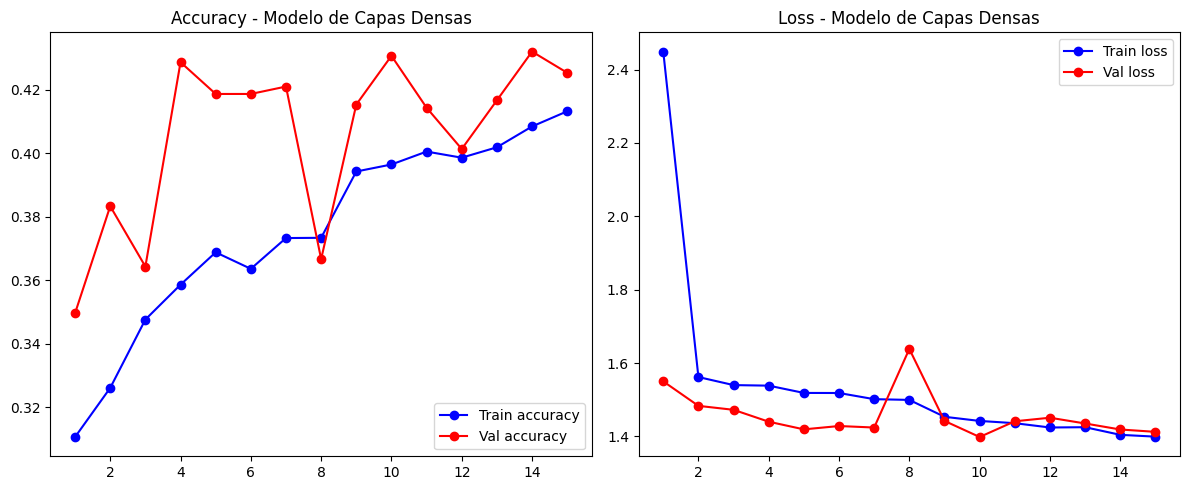

In [ ]:
# Graficamos la evolución del entrenamiento
plot_training(historial_denso, "Modelo de Capas Densas")

#### Conclusión

In [ ]:
# Creamos un data para comparar el rendimiento de los modelos
comparacion = pd.DataFrame({
  'Modelo': ['Modelo Denso'],
  'Precisión en test': [accuracy],
  'Pérdida en test': [loss]
})

In [ ]:
comparacion

Modelo  Precisión en test  Pérdida en test
0  Modelo Denso           0.430667          1.39834

El modelo de capas densas tiene un rendimiento moderado, con un 50% de acierto en las predicciones y una pérdida de 1.3, indicando que presenta dificultades para ajustarse a los datos. Este desempeño evidencia que las redes densas no son adecuadas para tareas de clasificación de imágenes, ya que tratan cada imagen como una secuencia plana de píxeles sin considerar su estructura espacial, limitando así la extracción de patrones visuales relevantes.

Según los resultados de la matriz de confusión:
- 'glacier' es correctamente clasificada.
- 'mountain' y 'sea' tienen un rendimiento aceptable.
- 'buildings' y 'street' no son correctamente clasificadas y presentan muchos errores distribuidos en otras clases.
- 'forest' tiene gran confusión con las clases glacier y street.

Según las curvas de entrenamiento:
- Accuracy: la precisión de validación es mayor que la de entrenamiento.
- Loss: la pérdida de validación es menor que la de entrenamiento.
El modelo puede estar sobreajustando.

En resumen, los resultados obtenidos significan que el modelo es inconsistente.

### Modelo con capas convolucionales y densas

In [ ]:
# Modelo con capas convolucionales y densas
def crear_modelo_conv_denso(input_shape, output_labels):
  i = Input(input_shape, dtype=tf.float32)

  # Estas capas aumentan la variedad del conjunto de datos "en vivo" durante el entrenamiento
  x = Rescaling(1./255)(i) # Normaliza la imagen a [0, 1]
  x = RandomFlip("horizontal")(x) # Giro horizontal
  x = RandomFlip("vertical")(x) # Giro vertical
  x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x) # Traslación
  x = RandomContrast(0.2)(x)  # Cambio de contraste

  x = Conv2D(8, (3, 3))(x) # Filtros conv con kernel 3x3
  x = BatchNormalization()(x) # Reduce el riesgo de overfitting
  x = Activation("relu")(x)

  x = Conv2D(16, (3, 3))(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x) # Activa las salidas de cada convolución

  x = MaxPooling2D((2, 2))(x) # Reduce la resolución espacial, conservando las características más importantes

  x = Conv2D(32, (3, 3))(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = MaxPooling2D((2, 2))(x)

  x = Conv2D(64, (3, 3))(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = MaxPooling2D((2, 2))(x)

  x = Flatten()(x)
  x = Dropout(0.5)(x) # Aumentamos a 0.5
  x = Dense(output_labels)(x)
  x = Activation("softmax")(x)
  return tf.keras.Model(inputs=[i], outputs=[x])

# Creamos el modelo
modelo_conv_denso = crear_modelo_conv_denso((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

# Compilamos el modelo
modelo_conv_denso.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

# Callbacks para evitar overfitting
callbacks = [
  EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
  ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
]

# Entrenamos el modelo
historia_conv_denso = modelo_conv_denso.fit(train_ds, validation_data=test_ds, epochs=20, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_8']
Received: inputs=Tensor(shape=(None, 150, 150, 3))
  warnings.warn(msg)


439/439 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - accuracy: 0.4458 - loss: 2.4357 - val_accuracy: 0.5557 - val_loss: 1.1362 - learning_rate: 0.0010
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step - accuracy: 0.5937 - loss: 1.1257 - val_accuracy: 0.5497 - val_loss: 1.1649 - learning_rate: 0.0010
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - accuracy: 0.6538 - loss: 0.9344 - val_accuracy: 0.6553 - val_loss: 0.9737 - learning_rate: 0.0010
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.7050 - loss: 0.7920 - val_accuracy: 0.6830 - val_loss: 0.8287 - learning_rate: 0.0010
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.7223 - loss: 0.7401 - val_accuracy: 0.7617 - val_loss: 0.6560 - learning_rate: 0.0010
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.7393 - loss: 0.6970 - val_accuracy: 0.7267 - val_loss: 0.7311 - learning_rate: 0.0010
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.7527 - loss: 0.6618

#### Modelo

In [ ]:
modelo_conv_denso.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 150, 150, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 150, 150, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 148, 148, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 146, 146, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 146, 146, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 71, 71, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 71, 71, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 35, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 33, 33, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 33, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             

 Total params: 369,476 (1.41 MB)

 Trainable params: 123,078 (480.77 KB)

 Non-trainable params: 240 (960.00 B)

 Optimizer params: 246,158 (961.56 KB)

#### Evaluación

In [ ]:
# Evaluamos el modelo con el conjunto de datos TEST
loss, accuracy = modelo_conv_denso.evaluate(test_ds)
print(f"Pérdida en test: {loss:.4f}")
print(f"Precisión en test: {accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8175 - loss: 0.5025
Pérdida en test: 0.4697
Precisión en test: 0.8310


 5/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step  

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_8']
Received: inputs=Tensor(shape=(32, 150, 150, 3))
  warnings.warn(msg)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


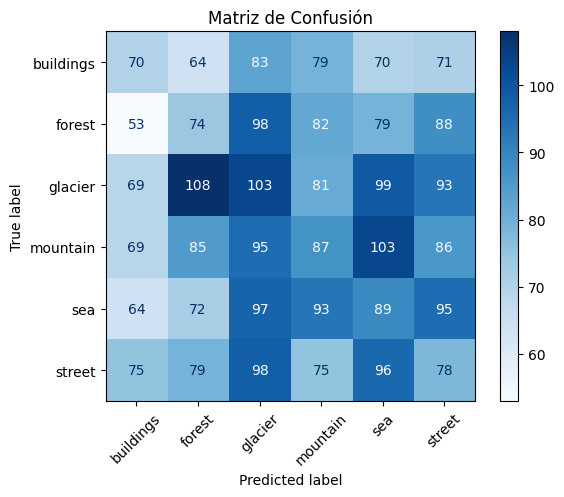


Matriz de Confusión con Nombres de Clases:
           buildings  forest  glacier  mountain  sea  street
buildings         70      64       83        79   70      71
forest            53      74       98        82   79      88
glacier           69     108      103        81   99      93
mountain          69      85       95        87  103      86
sea               64      72       97        93   89      95
street            75      79       98        75   96      78


In [ ]:
# Matriz de confusión
plot_confusion_matrix(modelo_conv_denso, test_ds)

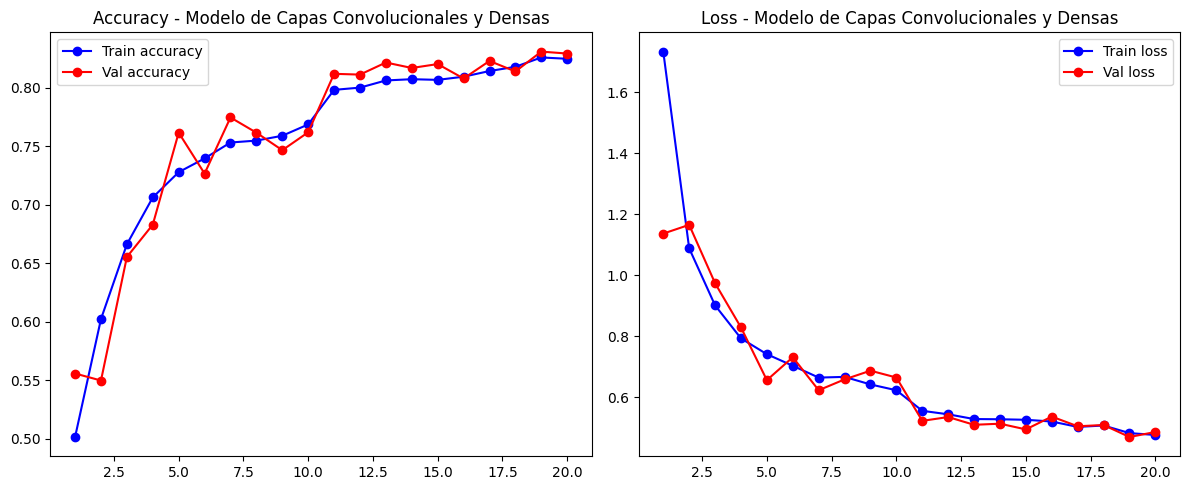

In [ ]:
plot_training(historia_conv_denso, "Modelo de Capas Convolucionales y Densas")

#### Conclusión

In [ ]:
metricas_modelo_denso = {
    'Modelo': 'Modelo Convolucional y Denso',
    'Precisión en test': accuracy,
    'Pérdida en test': loss
}
comparacion.loc[len(comparacion)] = metricas_modelo_denso
comparacion

Modelo  Precisión en test  Pérdida en test
0                  Modelo Denso           0.430667          1.39834
1  Modelo Convolucional y Denso           0.831000          0.46967

El modelo de capas convolucionales y densas tiene un buen rendimiento, con un 84% de acierto en las predicciones y una pérdida de 0.4, indicando que generaliza correctamente. Este desempeño evidencia que el uso de capas convolucionales permitió extraer características espaciales relevantes, mejorando significativamente el desempeño respecto al modelo de capas densas.

Según los resultados de la matriz de confusión:
- 'glacier' es correctamente clasificada.
- 'street', 'sea' y 'forest' tiene un buen rendimiento, pero algunas confusiones con glacier y mountain.
- 'buildings' tiene gran confusión con forest y sea.
- 'mountain' tiene gran consfusión con glacier y sea.

Según las curvas de entrenamiento:
- Accuracy: la precisión de entrenamiento y validación convergen de forma estable.
- Loss: la pérdida disminuye progresivamente en entrenamiento y validación.
El modelo se ajusta bien a los datos, sin sobreajuste.

En resumen, el modelo dio mejores resultados que el de capas densas. Además, el suo de técnicas de aumento de datos (data augmentation) contribuyó a mitigar el sobreajuste.

### Modelo que incluya bloques residuales identidad

In [ ]:
# Definimos el bloque residual
def resnet_block(x, filters, downsample=False):
  shortcut = x
  strides = (2, 2) if downsample else (1, 1)

  x = Conv2D(filters, (3, 3), strides=strides, padding='same', kernel_initializer='he_normal')(x)
  x = ReLU()(x)
  x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)

  if downsample:
    shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same', kernel_initializer='he_normal')(shortcut)

  x = Add()([x, shortcut])
  x = ReLU()(x)
  return x

In [ ]:
# Modelo con uso de boques residuales
def build_resnet_like_model(input_shape=(150, 150, 3), num_classes=6):
  inputs = Input(shape=input_shape)
  x = tf.keras.layers.Rescaling(1./255)(inputs)

  x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', kernel_initializer='he_normal')(x)
  x = ReLU()(x)
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  x = resnet_block(x, 64)
  x = resnet_block(x, 64)

  x = resnet_block(x, 128, downsample=True)
  x = resnet_block(x, 128)

  x = GlobalAveragePooling2D()(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  outputs = Dense(num_classes, activation='softmax')(x)
  return Model(inputs, outputs)

# Compilamos
model_resnet_like = build_resnet_like_model(input_shape=(150, 150, 3), num_classes=num_classes)
model_resnet_like.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks para evitar overfitting.
callbacks = [
  EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
  ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
]

# Entrenamos el modelo
history_resnet_like = model_resnet_like.fit(train_ds, validation_data=test_ds, epochs=20, callbacks=callbacks)

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - accuracy: 0.3901 - loss: 1.5245 - val_accuracy: 0.6347 - val_loss: 0.9630 - learning_rate: 1.0000e-04
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - accuracy: 0.6181 - loss: 0.9914 - val_accuracy: 0.6807 - val_loss: 0.8882 - learning_rate: 1.0000e-04
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.6980 - loss: 0.8233 - val_accuracy: 0.7227 - val_loss: 0.7523 - learning_rate: 1.0000e-04
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.7289 - loss: 0.7502 - val_accuracy: 0.7710 - val_loss: 0.6474 - learning_rate: 1.0000e-04
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.7618 - loss: 0.6547 - val_accuracy: 0.7480 - val_loss: 0.7030 - learning_rate: 1.0000e-04
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.7711 - loss: 0.6244 - val_accuracy: 0.7997 - val_loss: 0.5682 - learning_rate: 1.0000e-04
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/ste

#### Modelo

In [ ]:
model_resnet_like.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 150, 150,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 75, 75,    │      9,472 │ rescaling_2[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 75, 75,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 38, 38,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 38, 38,    │     36,928 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 38, 38,    │          0 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 38, 38,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 38, 38,    │          0 │ conv2d_6[0][0],   │
│                     │ 64)               │            │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 38, 38,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 38, 38,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 38, 38,    │          0 │ conv2d_7[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 38, 38,    │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 38, 38,    │          0 │ conv2d_8[0][0],   │
│                     │ 64)               │            │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 38, 38,    │          0 │ add_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 19, 19,    │     73,856 │ re_lu_4[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 19, 19,    │          0 │ conv2d_9[0][0]  

 Total params: 2,098,196 (8.00 MB)

 Trainable params: 699,398 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,398,798 (5.34 MB)

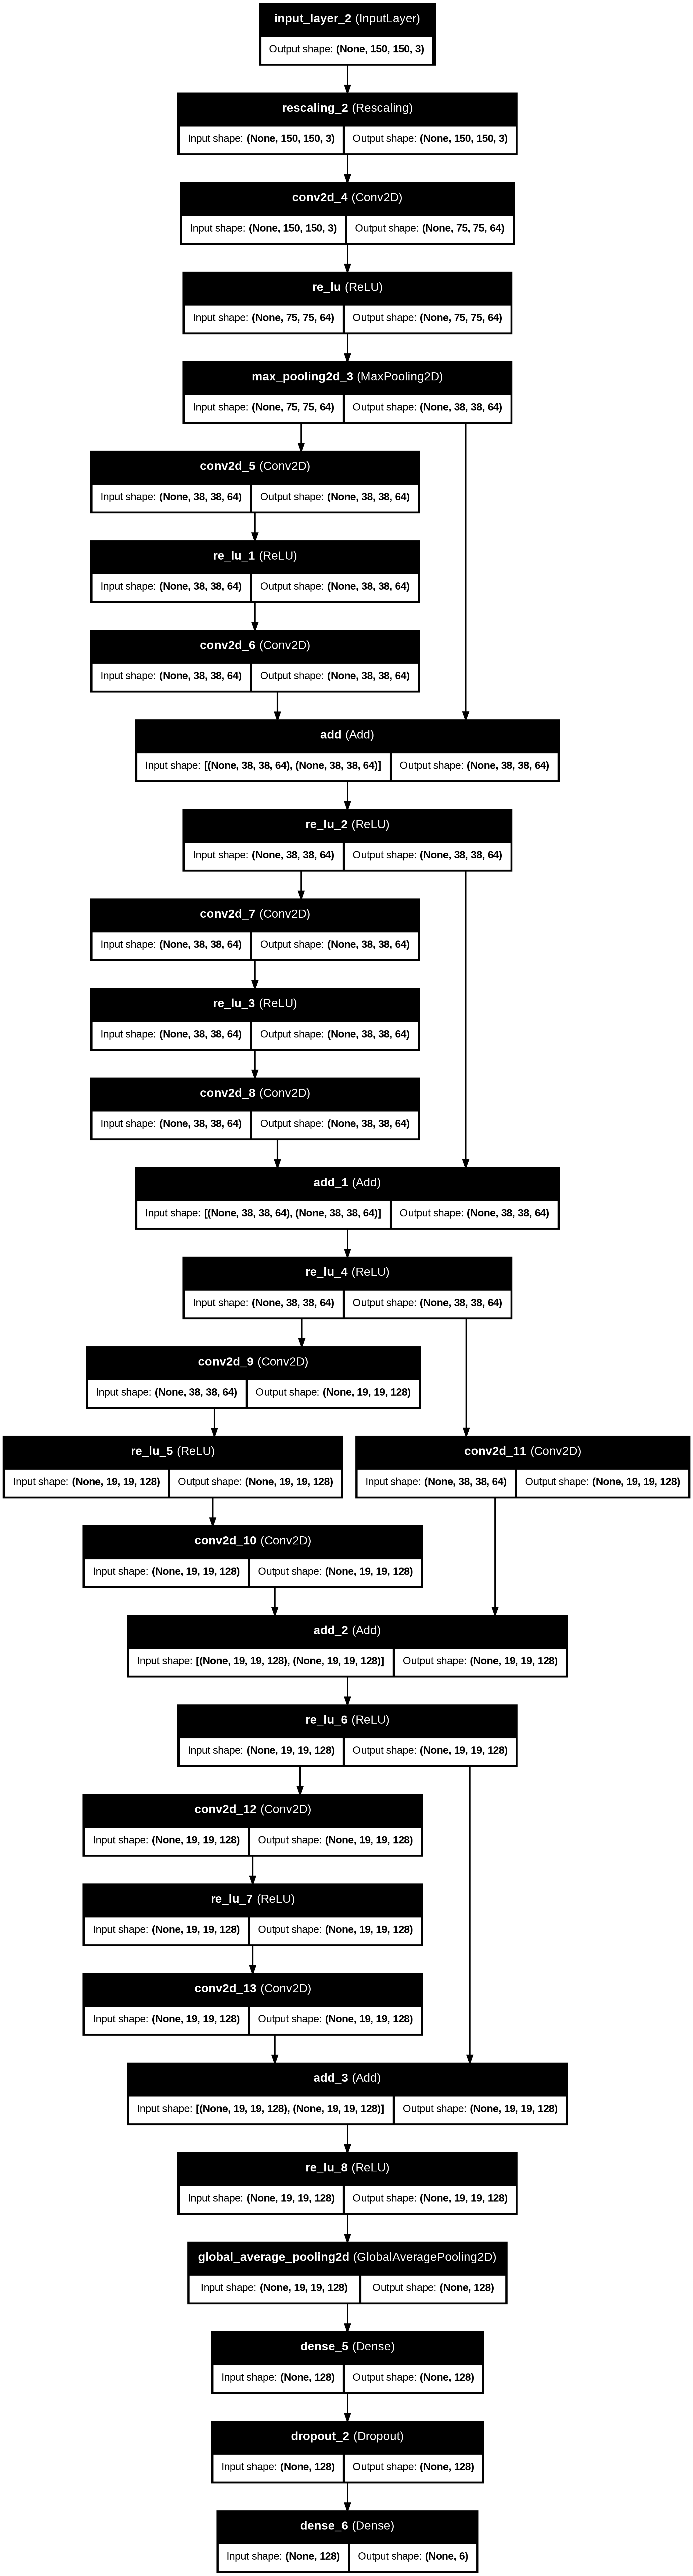

In [ ]:
# Creamos la imagen temporal del modelo
with tempfile.NamedTemporaryFile(suffix=".png") as tmpfile:
  plot_model(model_resnet_like, to_file=tmpfile.name, show_shapes=True, show_layer_names=True)
  display(Image(filename=tmpfile.name))

#### Evaluación

In [ ]:
# Evaluamos el modelo en el conjunto de datos TEST
test_loss, test_acc = model_resnet_like.evaluate(test_ds)
print(f"Accuracy en test: {test_acc:.4f}")
print(f"Pérdida en test: {test_loss:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8665 - loss: 0.3821
Accuracy en test: 0.8727
Pérdida en test: 0.3566


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


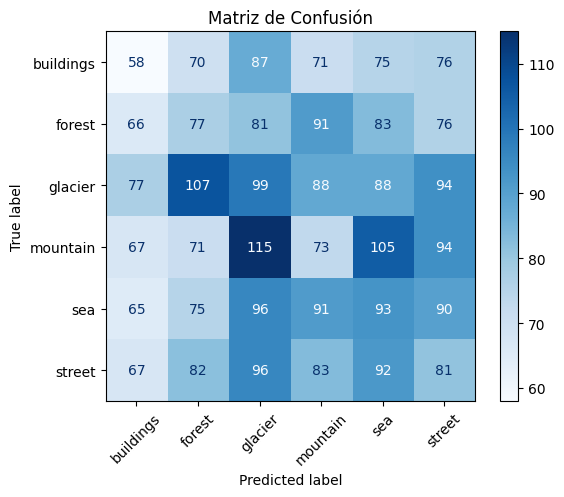


Matriz de Confusión con Nombres de Clases:
           buildings  forest  glacier  mountain  sea  street
buildings         58      70       87        71   75      76
forest            66      77       81        91   83      76
glacier           77     107       99        88   88      94
mountain          67      71      115        73  105      94
sea               65      75       96        91   93      90
street            67      82       96        83   92      81


In [ ]:
# Matriz de confusión
plot_confusion_matrix(modelo_conv_denso, test_ds)

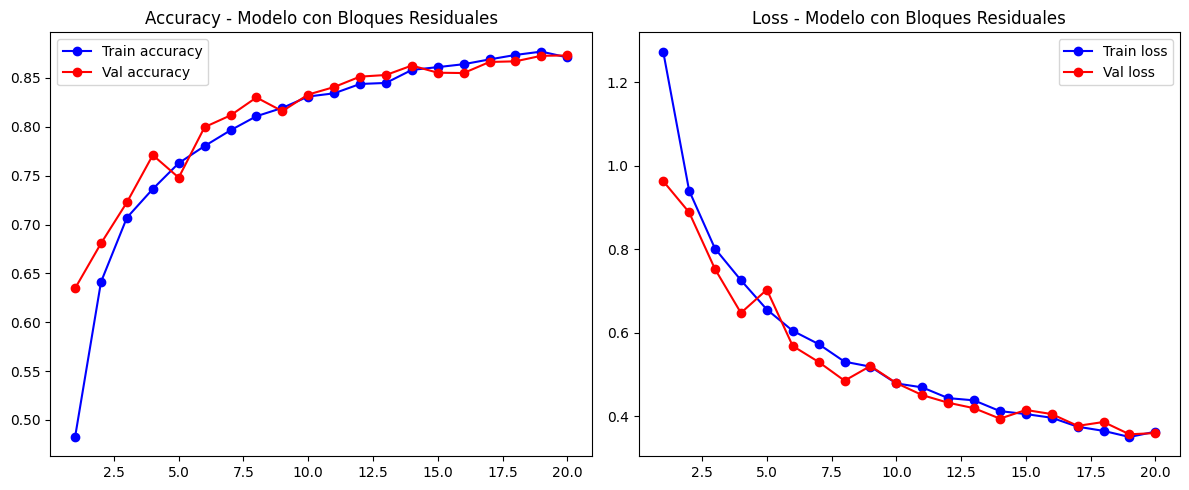

In [ ]:
# Graficamos la evolución del entrenamiento
plot_training(history_resnet_like, "Modelo con Bloques Residuales")

#### Conclusión

In [ ]:
metricas_bloques_residuales = {
    'Modelo': 'Modelo Bloques Residuales',
    'Precisión en test': test_acc,
    'Pérdida en test': test_loss
}
comparacion.loc[len(comparacion)] = metricas_bloques_residuales
comparacion

Modelo  Precisión en test  Pérdida en test
0                  Modelo Denso           0.430667         1.398340
1  Modelo Convolucional y Denso           0.831000         0.469670
2     Modelo Bloques Residuales           0.872667         0.356608

El modelo de capas convolucionales y densas tiene un buen rendimiento, con un 88% de acierto en las predicciones y una pérdida de 0.3, indicando que generaliza correctamente. La arquitectura permitió mejorar el desempeño mediante conexiones de atajo, manteniendo la estabilidad del entrenamiento.

Según los resultados de la matriz de confusión:
- 'glacier' tiene un buen rendimiento pero presenta confusión con sea.
- 'street' y 'forest' tienen un rendimiento aceptable, pero confusiones significativas con sea y mountain.
- 'sea' tiene un rendimiento aceptable, pero confusiones con glacier y street.
- 'buildings' tiene gran confusión con forest y glacier.
- 'mountain' tiene gran consfusión con glacier.

Según las curvas de entrenamiento:
- Accuracy: la precisión de entrenamiento y validación convergen de forma estable y cercana.
- Loss: la pérdida disminuye progresivamente en entrenamiento y validación.
El modelo se ajusta bien a los datos, sin sobreajuste.

En resumen, el modelo tuvo un desempeño aceptable.

### Modelo que utilice como backbone alguna arquitectura disponibles en TensorFlow (transfer learning)

EfficientNetB0



In [ ]:
# Modelo con el uso de TensorFlow (EfficientNetB0)
def build_tensorflow_model(input_shape, num_classes):
  base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
  base_model.trainable = False

  i = Input(shape=input_shape)
  x = base_model(i, training=False)
  x = GlobalAveragePooling2D()(x)

  x = Dropout(0.5)(x)
  x = Dense(num_classes, activation='softmax')(x)
  return tf.keras.Model(i, x)

# Creamos el modelo
model_tensorflow = build_tensorflow_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

# Compilamos el modelo
model_tensorflow.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

# Callbacks para evitar overfitting
callbacks = [
  EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
  ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# Entrenamos el modelo
historia_tf = model_tensorflow.fit(train_ds, validation_data=test_ds, epochs=20, batch_size=BATCH_SIZE, callbacks=callbacks)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 52s 72ms/step - accuracy: 0.7553 - loss: 0.6677 - val_accuracy: 0.9083 - val_loss: 0.2507 - learning_rate: 0.0010
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 53s 29ms/step - accuracy: 0.9053 - loss: 0.2613 - val_accuracy: 0.9170 - val_loss: 0.2276 - learning_rate: 0.0010
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9105 - loss: 0.2400 - val_accuracy: 0.9193 - val_loss: 0.2223 - learning_rate: 0.0010
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9181 - loss: 0.2257 - val_accuracy: 0.9227 - val_loss: 0.2162 - learning_rate: 0.0010
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9231 - loss: 0.2201 - val_accuracy: 0.9230 - val_loss: 0.2149 - learning_rate: 0.0010
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9216 - loss: 0.2192 - val_accuracy: 0.9210 - val_loss: 0.2139 - learning_rate: 0.0010
Epoch 7/20
439/439 ━━━━━━

#### Modelo

In [ ]:
model_tensorflow.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,072,631 (15.54 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 15,374 (60.06 KB)

En el summary podemos observar que del total params 4,057,257 sólo se van a entrenar 7,686 (por la compilación)

#### Evaluación

In [ ]:
# Evaluamos el modelo en el conjunto de datos TEST
loss, accuracy = model_tensorflow.evaluate(test_ds)
print(f"Pérdida en test: {loss:.4f}")
print(f"Precisión en test: {accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9150 - loss: 0.2458
Pérdida en test: 0.2100
Precisión en test: 0.9227


94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step


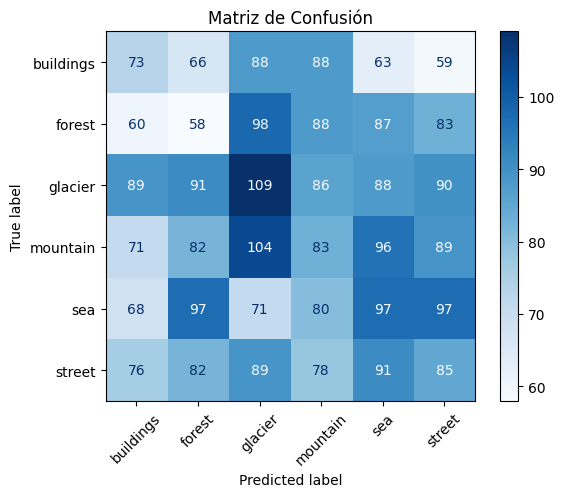


Matriz de Confusión con Nombres de Clases:
           buildings  forest  glacier  mountain  sea  street
buildings         73      66       88        88   63      59
forest            60      58       98        88   87      83
glacier           89      91      109        86   88      90
mountain          71      82      104        83   96      89
sea               68      97       71        80   97      97
street            76      82       89        78   91      85


In [ ]:
# Matriz de confusión
plot_confusion_matrix(model_tensorflow, test_ds)

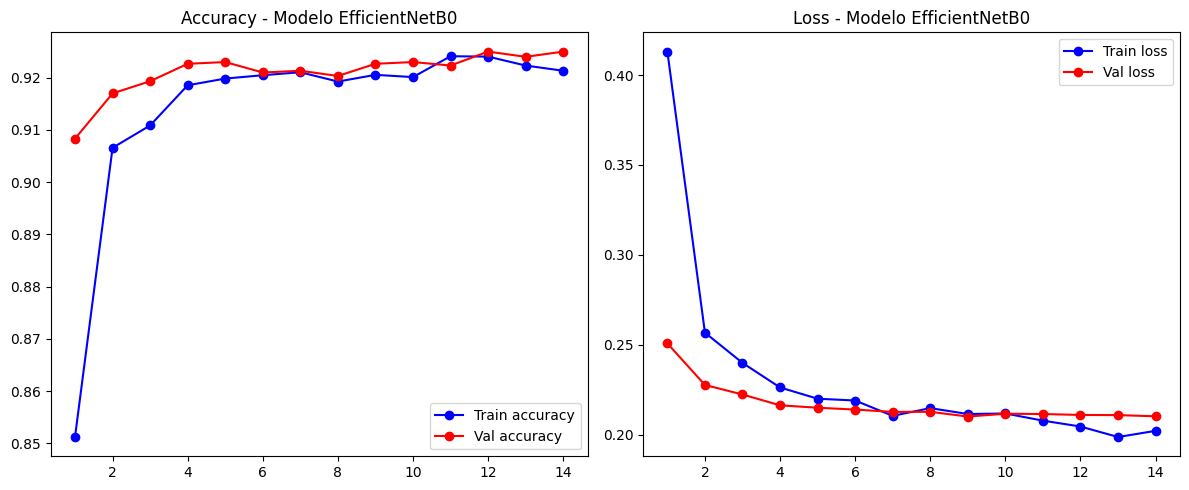

In [ ]:
plot_training(historia_tf, "Modelo EfficientNetB0")

#### Conclusión

In [ ]:
# agregamos nuevos datos al dataframe existente
metricas_tensorflow = {
    'Modelo': 'Modelo Tensorflow',
    'Precisión en test': accuracy,
    'Pérdida en test': loss
}
comparacion.loc[len(comparacion)] = metricas_tensorflow
comparacion

Modelo  Precisión en test  Pérdida en test
0                  Modelo Denso           0.430667         1.398340
1  Modelo Convolucional y Denso           0.831000         0.469670
2     Modelo Bloques Residuales           0.872667         0.356608
3             Modelo Tensorflow           0.922667         0.210008

El modelo EfficientNetB0 tiene un mejor rendimiento, con un 92% de acierto en las predicciones y una pérdida de 0.2. Este desempeño evidencia la efectividad del transfer learning, aprovechando características previamente aprendidas en grandes datasets y adaptándolas al problema actual con un costo computacional más bajo.

Según los resultados de la matriz de confusión:
- 'glacier' y 'forest' tiene un buen rendimiento pero presenta confusión con sea y mountain.
- 'street' y 'sea' tienen un rendimiento aceptable, pero confusiones significativas con glacier y mountain.
- 'buildings' tiene gran confusión con forest y sea.
- 'mountain' tiene gran consfusión con glacier y sea.

Según las curvas de entrenamiento:
- Accuracy: la precisión de entrenamiento y validación convergen rápidamente, manteniéndose estables y cercanas.
- Loss: la pérdida disminuye drásticamente en las primeras épocas y se estabiliza en un nivel muy bajo.
El modelo se ajusta bien a los datos, sin sobreajuste.

Exploramos otras técnicas de TensorFlow:

MobileNet
- Accuracy: 67%
- Loss: 0.7

ResNet50:
- Accuracy: 92%
- Loss: 0.9

EfficientNetB0 fue el que más se destacó entre ellos.
En resumen, el modelo tuvo un buen desempeño.

## **Conclusión Final y Comparación de modelos**



In [ ]:
comparacion

Modelo  Precisión en test  Pérdida en test
0                  Modelo Denso           0.430667         1.398340
1  Modelo Convolucional y Denso           0.831000         0.469670
2     Modelo Bloques Residuales           0.872667         0.356608
3             Modelo Tensorflow           0.922667         0.210008

A lo largo del ejercicio, vimos distintas arquitecturas de Redes Neuronales para clasificar imágenes de escenas naturales.

Comenzamos con un modelo denso simple y progresivamente incorporamos técnicas más sofisticadas como convoluciones, bloques residuales y TransferLearning.

En términos generales:

*   El modelo denso fue el menos efectivo, limitado por su incapacidad para aprovechar la estructura espacial de las imágenes.

*   El modelo convolucional denso demostró una mejora gracias al uso de filtros espaciales y data augmentation.

*   El modelo con bloques residuales mostró cómo arquitecturas más profundas pueden ser estables y eficientes si se diseñan adecuadamente.

*   El modelo con transferencia de aprendizaje (EfficientNetB0) fue el más eficiente y preciso, destacándose como la opción más robusta y práctica.

En conclusión: pudimos probar distintos tipos de redes neuronales y ver cómo cada mejora impacta en la clasificación de imágenes. Comprobamos que:
- Los modelos simples no son tan efectivos.
- Las redes convolucionales y los bloques residuales mejoran significativamente ya que aprovechan la estructura espacial.
- Los modelos preentrenados como EfficientNetB0, dan mejores resultados, logrando un balance entre precisión, eficiencia y costo computacional.